In [1]:
# # header
import sys
sys.path.append(r"../")

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from src.model import AttentionModel
from src.composer import PsychChange
from src.conductor import seq_cls_eval
from src.utils import plot_all, build_loaders, sigmoid, fit_sigmoid
from prelude import get_device, startup_folders, load_dicts
import matplotlib.pyplot as plt

In [3]:
start_folder = r"../pretrained/psycphys/change/"
results_folder, logger = startup_folders(start_folder, name=f"exp_a")

../pretrained/psycphys/change/1753272832 was created!


In [4]:
model_params = load_dicts(start_folder, "model_params")
tasks = load_dicts(start_folder, "tasks")
train_params = load_dicts(start_folder, "train_params")
DeVice, num_workers, pin_memory = get_device()
print(f"model_params: {model_params}")
print(f"tasks: {tasks}")
print(f"train_params: {train_params}")
train_params["batch_size"] = 256
tasks

Device set to mps
model_params: {'in_dims': [1, 96, 96], 'n_classes': 9, 'out_dim': 9, 'normalize': True, 'softness': 0.5, 'channels': [1, 4, 8, 16, 32, 32], 'residuals': False, 'kernels': 3, 'strides': 2, 'paddings': 1, 'conv_bias': True, 'conv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'conv_dropouts': 0.0, 'conv_funs': ReLU(), 'deconv_funs': Tanh(), 'deconv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'pools': [1, 1, 1, 1, 1], 'rnn_dims': [16, 16], 'rnn_bias': True, 'rnn_dropouts': 0.0, 'rnn_funs': ReLU(), 'n_tasks': 1, 'task_layers': 1, 'task_weight': True, 'task_bias': True, 'task_funs': Tanh(), 'norm_mean': [0.5], 'norm_std': [0.25], 'rnn_to_fc': False, 'trans_fun': Identity()}
tasks: {'RotationChangeDetection': {'composer': 'PsychChange', 'key': 0, 'params': {'episodes': [0, 2, 0, 3], 'r_range': 30, 'r_base': 5, 'biased': 0.5, 'force_range': False, 'force_label': False, 'n_objects': -1, 'noise': 0.25}, 'datasets': ['PsychChange', 'PsychChange', 'PsychChange'], 'd

{'RotationChangeDetection': {'composer': 'PsychChange',
  'key': 0,
  'params': {'episodes': [0, 2, 0, 3],
   'r_range': 30,
   'r_base': 5,
   'biased': 0.5,
   'force_range': False,
   'force_label': False,
   'n_objects': -1,
   'noise': 0.25},
  'datasets': ['PsychChange', 'PsychChange', 'PsychChange'],
  'dataloaders': [None, None, None],
  'loss_w': [[1.0, 1.0], [1.0, 1.0]],
  'loss_s': [[-2, -1], [0, 1]]}}

In [5]:
# datasets and dataloaders
t = "RotationChangeDetection"
tasks[t]["composer"] = PsychChange
tasks[t]["datasets"] = []
tasks[t]["dataloaders"] = []

# datasets and dataloaders
for t in tasks:
    tasks[t]["datasets"].append(tasks[t]["composer"](**tasks[t]["params"], n_samples=train_params["n_samples"]))
    tasks[t]["datasets"].append(tasks[t]["composer"](**tasks[t]["params"], n_samples=1024))
    tasks[t]["datasets"].append(tasks[t]["composer"](**tasks[t]["params"], n_samples=1024))
    tasks[t]["dataloaders"] = build_loaders(tasks[t]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# create a blank model
model = AttentionModel(**model_params)

# load states into the model
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

<All keys matched successfully>

In [6]:
t = "RotationChangeDetection"
rotation_range = torch.arange(1, 21).tolist()
biased_range = (-1.0, 0.0, 1.0)
n_objects_range = torch.arange(1, 9).tolist()
noise_range = (0.125, )
neutral_cue_range = (False, True)

ce_stuff = torch.zeros(2, len(biased_range), len(n_objects_range), len(noise_range), len(rotation_range), len(tasks[t]["loss_s"][0]))
acc_stuff = torch.zeros(2, len(biased_range), len(n_objects_range), len(noise_range), len(rotation_range), len(tasks[t]["loss_s"][0]))

tasks[t]["dataloaders"][1].dataset.r_base = 1
tasks[t]["dataloaders"][1].dataset.force_range = True
tasks[t]["dataloaders"][1].dataset.force_label = True
tasks[t]["dataloaders"][1].dataset.n_samples = 512
for nc, ncnc in enumerate(neutral_cue_range):
    tasks[t]["dataloaders"][1].dataset.force_neutral = ncnc
    for b, bb in enumerate(biased_range):
        tasks[t]["dataloaders"][1].dataset.biased = bb
        if (ncnc and bb == 0.0) or (not ncnc):
            for ob, obob in enumerate(n_objects_range):
                tasks[t]["dataloaders"][1].dataset.n_objects = obob
                for n, nn in enumerate(noise_range):
                    tasks[t]["dataloaders"][1].dataset.noise = nn
                    plot_all(10, model, tasks, results_folder, f"_{ncnc}_{bb}_{obob}_{nn}", DeVice, logger, False, "valid")
                    for r, rr in enumerate(rotation_range):
                        tasks[t]["dataloaders"][1].dataset.r_range = rr
                        
                        ce_, acc_, mask_ = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=False)
                        for i, _ in enumerate(tasks[t]["loss_s"][0]):
                            ce_stuff[nc][b][ob][n][r][i] = ce_[i]
                            acc_stuff[nc][b][ob][n][r][i] = acc_[i]

print(f"CE Stuff: {ce_stuff.shape}, Acc Stuff: {acc_stuff.shape}")
# plot_all(10, model, tasks, results_folder, "_just_", DeVice, logger)


CE Stuff: torch.Size([2, 3, 8, 1, 20, 2]), Acc Stuff: torch.Size([2, 3, 8, 1, 20, 2])


In [7]:
torch.save(rotation_range, os.path.join(results_folder, "rotation_range.pth"))
torch.save(biased_range, os.path.join(results_folder, "biased_range.pth"))
torch.save(n_objects_range, os.path.join(results_folder, "n_objects_range.pth"))
torch.save(noise_range, os.path.join(results_folder, "noise_range.pth"))
torch.save(ce_stuff, os.path.join(results_folder, "ce_stuff.pth"))
torch.save(acc_stuff, os.path.join(results_folder, "acc_stuff.pth"))

Params for biased 0.0 n0.125 ob1: [1.26184803e+00 7.94155452e+00 9.93630653e-01 6.49509910e-03]
Params for biased 0.0 n0.125 ob2: [ 1.13687415  8.74113447  1.01284611 -0.01326736]
Params for biased 0.0 n0.125 ob4: [ 1.23251806e+00  9.55464189e+00  9.99319984e-01 -5.76034672e-03]
Params for biased 0.0 n0.125 ob8: [ 1.19328264e+00  1.00336405e+01  1.00110555e+00 -9.04049230e-03]


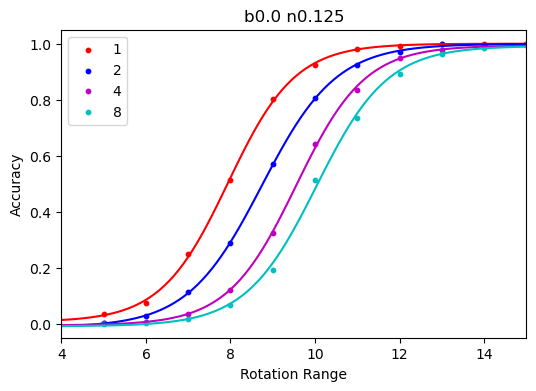

In [14]:
n, nn = 0, noise_range[0]
b, bb = 1, biased_range[1]
frng, trng = 4, 15
colors = ['r', 'b', 'm', 'c', 'k']
x = torch.tensor(rotation_range[frng:trng])
xx = torch.linspace(frng, rotation_range[frng:trng][-1], 100)
plt.figure(figsize=(6, 4))
plt.title(f"b{bb} n{nn}")
for ci, ob in enumerate((0, 1, 3, 7)):
    obob = n_objects_range[ob]
    y = acc_stuff[1, b, ob, n, frng:trng, 0]
    plt.scatter(x, y, color=colors[ci], label=f"{obob}", s=10)
    params = fit_sigmoid(x, y)
    print(f"Params for biased {bb} n{nn} ob{obob}: {params}")
    plt.plot(xx, sigmoid(xx, *params), color=colors[ci])

# ob = -1
# b = -1
# obob = n_objects_range[ob]
# y = acc_stuff[0, b, ob, n, frng:trng, 0]
# plt.scatter(x, y, color=colors[-1], label=f"{obob}", s=10)
# params = fit_sigmoid(x, y)
# print(f"Params for biased {bb} n{nn} ob{obob}: {params}")
# plt.plot(xx, sigmoid(xx, *params), color=colors[-1])

plt.ylim(-0.05, 1.05)
plt.xlim(frng, trng)
plt.xlabel("Rotation Range")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(results_folder, f"biased{bb}_noise{nn}_acc_vs_rot_load.svg"), format="svg")
plt.show()


Params for biased -1.0 n0.125 ob2: [ 1.21697267e+00  1.04572018e+01  9.94107259e-01 -7.86014910e-03]
Params for biased 0.0 n0.125 ob2: [ 1.13687415  8.74113447  1.01284611 -0.01326736]
Params for biased 1.0 n0.125 ob2: [ 1.14775475  8.18207521  1.02148104 -0.02292137]


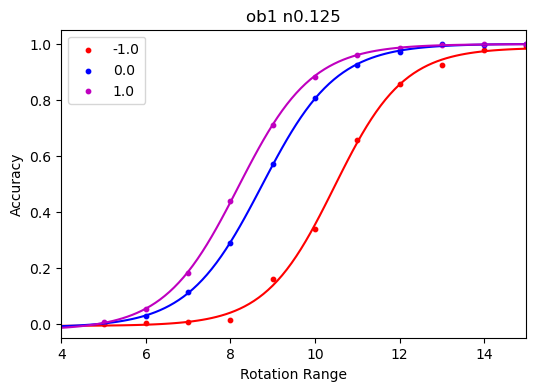

In [15]:
n, nn = 0, noise_range[0]
ob, obob = 1, n_objects_range[1]
frng, trng = 4, 15
colors = ['r', 'b', 'm', 'c']
x = torch.tensor(rotation_range[frng:trng])
xx = torch.linspace(frng, rotation_range[frng:trng][-1], 100)
plt.figure(figsize=(6, 4))
plt.title(f"ob{ob} n{nn}")
for b, bb in enumerate(biased_range):
    nc = 1 if bb == 0.0 else 0
    y = acc_stuff[nc, b, ob, n, frng:trng, 0]
    plt.scatter(x, y, color=colors[b], label=f"{bb}", s=10)
    params = fit_sigmoid(x, y)
    print(f"Params for biased {bb} n{nn} ob{obob}: {params}")
    plt.plot(xx, sigmoid(xx, *params), color=colors[b])
plt.ylim(-0.05, 1.05)
plt.xlim(frng, trng)
plt.xlabel("Rotation Range")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(results_folder, f"biased{bb}_noise{nn}_acc_vs_rot_bias.svg"), format="svg")
plt.show()
